# `xarray-leaflet`

`xarray-leaflet` is an xarray extension for plotting tiled maps. Both [xarray](https://docs.xarray.dev/en/stable/) and [Leaflet](ipyleaflet.ipynb) can work with data fragments, xarray with [dask chunks](https://docs.dask.org/en/latest/array-chunks.html) and leaflet with *map tiles*. With `xarray-leaflet` both work together.

## Installation

You can install `xarray-leaflet` in your Jupyter kernel with:

``` bash
$ pipenv install xarray-leaflet
Installing xarray-leaflet…
…
``` 

By default, `xarray-leaflet` generates tiles in temporary directories. With dynamic maps, a new directory is created each time the map is interacted with, either by dragging or zooming. This is because there is a direct mapping between the tile directory and the URL under which the tiles are provided. As tiles should not be cached by the browser for dynamic maps, the URL must change constantly. These temporary directories are currently not cleaned up automatically. You should therefore do this regularly yourself. In ix systems they are stored at `/tmp/xarray_leaflet_*`.

## Example

To be able to run the example, you must also install the following packages in your kernel:

* requests
* tqdm
* xarray-leaflet
* dask

In [1]:
import os
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import requests
import rioxarray
import xarray_leaflet

from ipyleaflet import LayersControl, Map, WidgetControl, basemaps
from ipywidgets import FloatSlider
from tqdm import tqdm

We will display the DEM (Digital Elevation Model) for Europe from the [HydroSHEDS](https://www.hydrosheds.org) dataset, which represents the terrain. Let’s download the data first:

In [2]:
url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/hydrosheds/sa_30s_zip_grid/eu_dem_30s_grid.zip'
filename = os.path.basename(url)
name = filename[:filename.find('_grid')]
adffile = os.path.join(name, name, 'w001001.adf')

if not os.path.exists(adffile):
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        total_length = int(r.headers.get('content-length'))
        for chunk in tqdm(r.iter_content(chunk_size=1024), total=(total_length/1024) + 1):
            if chunk:
                f.write(chunk)
                f.flush()
    zip = zipfile.ZipFile(filename)
    zip.extractall('.')

It’s a dataset that [Rasterio](https://rasterio.readthedocs.io/en/stable/) can open, but to get a nice `DataArray` with all the metadata, we open it with [rioxarray](https://corteva.github.io/rioxarray/stable/):

In [3]:
da = rioxarray.open_rasterio(adffile, masked=True)
da

<xarray.DataArray (band: 1, y: 5760, x: 9480)>
[54604800 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -14.0 -13.99 -13.98 -13.97 ... 64.98 64.99 65.0
  * y            (y) float64 60.0 59.99 59.98 59.97 ... 12.03 12.02 12.01 12.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

The projection is `EPSG:4326` (also known as `WGS84`). The coordinate `x` corresponds to the longitude and `y` to the latitude (in degrees). There is only one band.

In [4]:
da = da.sel(band=1)
da.name = "DEM"

The dataset may be too large to hold in memory, so we will break it down into smaller pieces. This will also improve performance as the generation of a tile can be done in parallel with Dask.

In [5]:
da = da.chunk((1000, 1000))
warnings.filterwarnings("ignore")

We simply need to create a map before passing it to our DataArray extension.

In [6]:
m = Map(
    center=[52.5162, 13.3777],
    zoom=3,
    basemap=basemaps.CartoDB.Positron,
    interpolation="nearest",
)
m

Map(center=[52.5162, 13.3777], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

To display our data on the map, we call `leaflet.plot()` with our `DataArray` and pass the map as a parameter. We get back a layer that we can control further, for example with a slider to adjust the opacity.

In [7]:
l = da.leaflet.plot(m, colormap=plt.cm.terrain)
l.interact(opacity=(0., 1.))

Url()

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

Now we will insert the slider into the map. We will also insert a layer control.

In [8]:
layers_control = LayersControl(position="topright")
m.add_control(layers_control)

opacity_slider = FloatSlider(description="Opacity:", min=0, max=1, value=1)


def set_opacity(change):
    l.opacity = change["new"]


opacity_slider.observe(set_opacity, names="value")
slider_control = WidgetControl(widget=opacity_slider, position="bottomleft")
m.add_control(slider_control)

The `select()` method allows you to select a region by clicking and dragging a box on the map. To do this, however, you must click on the ⏹️ button.

In [9]:
da.leaflet.select()

You can then retrieve the selected data field and plot it, for example.

In [10]:
da_selected = da.leaflet.get_selection()

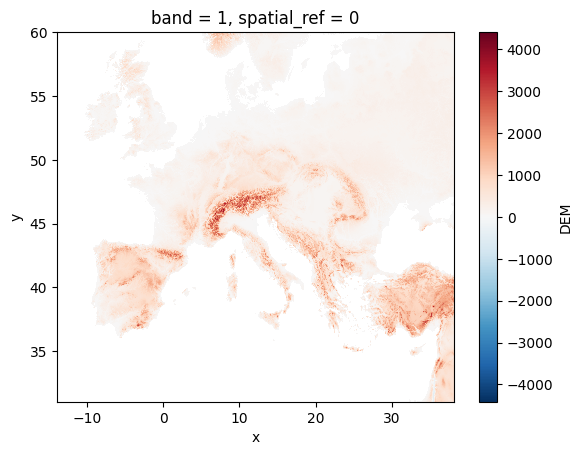

In [11]:
if da_selected is not None:
    da_selected.plot.imshow()    

Finally, the selection and the buttons can be removed:

In [12]:
da.leaflet.unselect()